In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

#warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data_fe.csv")
df.head()

,disbursed_amount,asset_cost,ltv,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,DisbursalDate_Month_8,DisbursalDate_Month_9,DisbursalDate_Month_10,DisbursalDate_Month_11,DisbursalDate_Month_12,PERFORM_CNS.SCORE.DESCRIPTION_1,PERFORM_CNS.SCORE.DESCRIPTION_2,PERFORM_CNS.SCORE.DESCRIPTION_3,PERFORM_CNS.SCORE.DESCRIPTION_4,PERFORM_CNS.SCORE.DESCRIPTION_5
0,10.831292,10.975088,89.55,1,0,0,0,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,10.761004,11.090584,73.23,1,0,0,0,0,598,0.0,...,False,True,False,False,False,False,False,True,False,False
2,10.883298,11.024530,89.63,1,0,0,0,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,10.959784,11.099136,88.48,1,0,0,0,0,305,0.0,...,False,False,True,False,False,True,False,False,False,False
4,10.866261,11.007104,88.39,1,0,0,0,0,0,0.0,...,False,True,False,False,False,False,False,False,False,False


In [3]:
X = df.drop('loan_default',axis=1)
y = df['loan_default']
model_scores={}

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [5]:
y_train.shape

(163207,)

In [6]:
X_test.shape,y_test.shape

((69947, 152), (69947,))

In [7]:
#dict to store various model results for comparison
results = {}

In [8]:
#model result is a function for model building and calculating scores
def modelresult(model_name,i):
    print(i,"\n")
    classifier = i
    classifier.fit(X_train, y_train)
    y_predt=classifier.predict(X_train)
    y_pred=classifier.predict(X_test)
    y_pred_prob=classifier.predict_proba(X_test)[:,1]
    results[model_name] = {'Accuracy' : accuracy_score(y_test,y_pred), 'roc_auc_score' : roc_auc_score(y_test,y_pred_prob)}
    print("\n Accuracy for the Train:",accuracy_score(y_train,y_predt))
    print("\n Accuracy for the Test",accuracy_score(y_test,y_pred),"\n")
    print("\n ROC AUC score",roc_auc_score(y_test,y_pred_prob),"\n")
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

Logistic Regression

In [9]:
lr = LogisticRegression(random_state=1)
modelresult("Linear Reg",lr)

LogisticRegression(random_state=1) 


 Accuracy for the Train: 0.7828463239934562

 Accuracy for the Test 0.783050023589289 


 ROC AUC score 0.6266518591325527 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54776
           1       0.46      0.00      0.00     15171

    accuracy                           0.78     69947
   macro avg       0.62      0.50      0.44     69947
weighted avg       0.71      0.78      0.69     69947



In [10]:
pd.DataFrame(results)

,Linear Reg
Accuracy,0.783050
roc_auc_score,0.626652


Logistic + WOE

In [11]:
def calculate_woe(df, feature, target):
    df = df[[feature, target]].copy()
    df['bucket'], bins = pd.qcut(df[feature], q=10, retbins=True, duplicates='drop')
    grouped = df.groupby('bucket')[target].agg(['count', 'sum'])
    grouped['non_events'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_events'] / grouped['non_events'].sum()
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    woe = grouped['woe'].to_dict()
    return woe

def replace_with_woe(df, feature, woe):
    df[feature + '_woe'] = df[feature].map(woe)
    return df

woe_dict = {}
for feature in X.columns:
    woe_dict[feature] = calculate_woe(df, feature, 'loan_default')
    df = replace_with_woe(df, feature, woe_dict[feature])

X_woe = df.drop(['loan_default'], axis=1)
y_woe = df['loan_default']


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_woe_imputed = imputer.fit_transform(X_woe)

X_train_woe_imputed, X_test_woe_imputed, y_train_woe_imputed, y_test_woe_imputed = train_test_split(X_woe_imputed, y_woe, test_size=0.3, random_state=2)

lr_woe_imputed = LogisticRegression(random_state=1)
lr_woe_imputed.fit(X_train_woe_imputed, y_train_woe_imputed)

y_pred_train_imputed = lr_woe_imputed.predict(X_train_woe_imputed)
y_pred_test_imputed = lr_woe_imputed.predict(X_test_woe_imputed)
y_pred_prob_test_imputed = lr_woe_imputed.predict_proba(X_test_woe_imputed)[:, 1]

print("Accuracy on Train:", accuracy_score(y_train_woe_imputed, y_pred_train_imputed))
print("Accuracy on Test:", accuracy_score(y_test_woe_imputed, y_pred_test_imputed))
print("ROC AUC Score:", roc_auc_score(y_test_woe_imputed, y_pred_prob_test_imputed))
print(classification_report(y_test_woe_imputed, y_pred_test_imputed))

Accuracy on Train: 0.7829504861923815
Accuracy on Test: 0.7829499478176334
ROC AUC Score: 0.633058394754499
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54776
           1       0.44      0.00      0.01     15171

    accuracy                           0.78     69947
   macro avg       0.61      0.50      0.44     69947
weighted avg       0.71      0.78      0.69     69947



Decision Tree classifier

In [13]:
dcg = DecisionTreeClassifier(criterion='entropy',random_state=1)
modelresult("DT-Entropy" ,dcg)

DecisionTreeClassifier(criterion='entropy', random_state=1) 


 Accuracy for the Train: 0.9997365309086007

 Accuracy for the Test 0.6739388394069795 


 ROC AUC score 0.5266690949744165 

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     54776
           1       0.26      0.27      0.26     15171

    accuracy                           0.67     69947
   macro avg       0.53      0.53      0.53     69947
weighted avg       0.68      0.67      0.68     69947



Decision Tree classifier with gini

In [14]:
dcg = DecisionTreeClassifier(criterion='gini',random_state=1)
modelresult("DT-Gini",dcg)

DecisionTreeClassifier(random_state=1) 


 Accuracy for the Train: 0.9997365309086007

 Accuracy for the Test 0.6742104736443307 


 ROC AUC score 0.530462374878385 

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     54776
           1       0.26      0.28      0.27     15171

    accuracy                           0.67     69947
   macro avg       0.53      0.53      0.53     69947
weighted avg       0.68      0.67      0.68     69947



RandomForest Classifier

In [15]:
rfc = RandomForestClassifier(n_estimators=100,random_state=1)
modelresult("RandomForest",rfc)

RandomForestClassifier(random_state=1) 


 Accuracy for the Train: 0.9997181493440845

 Accuracy for the Test 0.7772742219108754 


 ROC AUC score 0.6274546956237763 

              precision    recall  f1-score   support

           0       0.79      0.98      0.87     54776
           1       0.39      0.05      0.08     15171

    accuracy                           0.78     69947
   macro avg       0.59      0.51      0.48     69947
weighted avg       0.70      0.78      0.70     69947



Bagging Classifier

In [16]:
bgc = BaggingClassifier(random_state=1)
modelresult("Bagging",bgc)  

BaggingClassifier(random_state=1) 


 Accuracy for the Train: 0.9753993394891151

 Accuracy for the Test 0.7659513631749754 


 ROC AUC score 0.5911332229505887 

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     54776
           1       0.34      0.09      0.14     15171

    accuracy                           0.77     69947
   macro avg       0.57      0.52      0.50     69947
weighted avg       0.69      0.77      0.71     69947



AdaBoost Classifier

In [17]:
ada = AdaBoostClassifier(random_state=1)
modelresult("Adaboost", ada)

AdaBoostClassifier(random_state=1) 


 Accuracy for the Train: 0.7826073636547451

 Accuracy for the Test 0.7827783893519379 


 ROC AUC score 0.6536466632755027 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54776
           1       0.48      0.02      0.03     15171

    accuracy                           0.78     69947
   macro avg       0.63      0.51      0.45     69947
weighted avg       0.72      0.78      0.69     69947



XGBoost Classifier

In [18]:
xgb =  XGBClassifier(random_state=1, n_jobs=-1, learning_rate=0.2,n_estimators=100, max_depth=3)
modelresult("XGboost",xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...) 


 Accuracy for the Train: 0.7836551128321702

 Accuracy for the Test 0.7838506297625345 


 ROC AUC score 0.6643697958842921 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54776
           1  

In [19]:
pd.DataFrame(results).T

,Accuracy,roc_auc_score
Linear Reg,0.783050,0.626652
DT-Entropy,0.673939,0.526669
DT-Gini,0.674210,0.530462
RandomForest,0.777274,0.627455
Bagging,0.765951,0.591133
Adaboost,0.782778,0.653647
XGboost,0.783851,0.664370


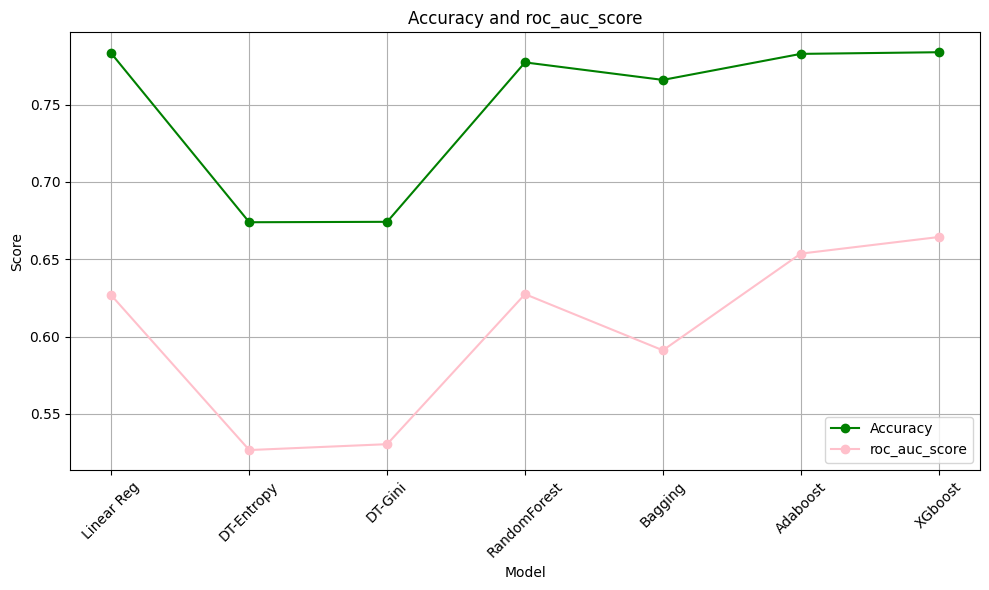

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Accuracy'], marker='o', color='green', label='Accuracy')

plt.plot(df.index, df['roc_auc_score'], marker='o', color='pink', label='roc_auc_score')

plt.title('Accuracy and roc_auc_score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(df.index, ["Linear Reg", "DT-Entropy", "DT-Gini", "RandomForest", "Bagging", "Adaboost", "XGboost"], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can observe that Xgboost classifier has highest accuracy score of 78.3% and roc_auc_score of 66% of all models built